# Predicting Heart Disease

### By Will Langas

## Data Source:
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, permutation_test_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
plt.rcParams['font.size'] = '12'

In [3]:
# https://stackoverflow.com/questions/51752298/seeking-a-faster-way-to-drop-all-placeholders-from-pandas-dataframe
# https://towardsdatascience.com/how-to-use-data-files-from-uci-68b740b4719d

df =  pd.read_csv('processed.cleveland.data', sep=",", na_values=["?"]) # NaN values are represented as ? in the dataset
orig_cols = df.columns
df = df.dropna()

print("Number of Datapoints: ", len(df))
df.head()

Number of Datapoints:  296


,63.0,1.0,1.0.1,145.0,233.0,1.0.2,2.0,150.0,0.0,2.3,3.0,0.0.1,6.0,0
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


## Data Cleaning

As seen above, the data is currently in a very confusing format, since the column names are represented as values instead of their actual meaning, thus, we will rename the columns in the following cell

In [4]:
df["Age"] = df["63.0"]
df["Sex"] = df["1.0"]
df["Chest Pain"] = df["1.0.1"]
df["Rest BP"] = df["145.0"]
df["Chol"] = df["233.0"]
df["Blood Sugar"] = df["1.0.2"]
df["Rest ECG"] = df["2.0"]
df["Max HR"] = df["150.0"]
df["Exercise"] = df["0.0"]
df["Peak"] = df["2.3"]
df["Slope"] = df["3.0"]
df["Vessels"] = df["0.0.1"]
df["Thal"] = df["6.0"]
df["Output"] = df["0"]

df = df.drop(columns = orig_cols)
df.head()

,Age,Sex,Chest Pain,Rest BP,Chol,Blood Sugar,Rest ECG,Max HR,Exercise,Peak,Slope,Vessels,Thal,Output
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


Our analysis is simply looking for the presence of heart disease, not the types of heart disease, therefore we will alter the data so the any value 0-4 is either a 0 or 1. As according to the critiria stated in the original dataset:

"58 num: diagnosis of heart disease (angiographic disease status)
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing"

In [5]:
df.loc[df['Output'] > 0, 'Output'] = 1 
df.loc[df['Output'] == 0, 'Output'] = 0 

## Outlier Testing and Filtering

In [6]:
info = df.describe()
info

,Age,Sex,Chest Pain,Rest BP,Chol,Blood Sugar,Rest ECG,Max HR,Exercise,Peak,Slope,Vessels,Thal,Output
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.513514,0.675676,3.165541,131.648649,247.398649,0.141892,0.993243,149.597973,0.327703,1.051351,1.597973,0.679054,4.726351,0.462838
std,9.051631,0.468915,0.958262,17.775956,52.078915,0.349530,0.994879,22.980401,0.470171,1.165841,0.613848,0.939726,1.940500,0.499461
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.250000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


- In the Cholesterol column, we see that the maximum value is 564, versus an average of ~250. In the following section we will perform analysis to determine if there are outliers, and filter accordingly in the Cholesterol column
- We will only do this in Cholesterol column, since 564 is more than two times what is considered "High" cholesterol, and there are most likely other factors like underlying conditions at play here that could skew analysis
https://www.cnn.com/2009/HEALTH/11/24/moh.healthmag.cholesterol.surprises/index.html

In [7]:
# https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244

IQR = df["Chol"].quantile(0.75) - df["Chol"].quantile(0.25)

max_chol = (1.5 * IQR) + df["Chol"].quantile(0.75)
min_chol = df["Chol"].quantile(0.25) - (1.5 * IQR) 

df = df[df["Chol"] <= max_chol]
df = df[df["Chol"] >= min_chol]

print("Number of Datapoints: ", len(df))
df.head()

Number of Datapoints:  291


,Age,Sex,Chest Pain,Rest BP,Chol,Blood Sugar,Rest ECG,Max HR,Exercise,Peak,Slope,Vessels,Thal,Output
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


## Dataset Information

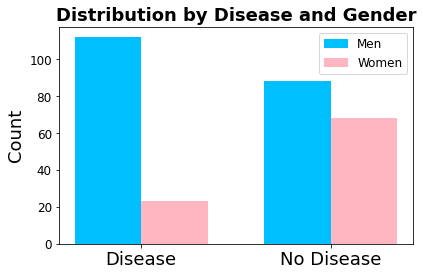

In [8]:
disease = df[df["Output"] == 1]
no_disease = df[df["Output"] == 0]

labels = ['Disease', 'No Disease']
men_vals = [len(disease[disease["Sex"] == 1]), len(no_disease[no_disease["Sex"] == 1])]
women_vals = [len(disease[disease["Sex"] == 0]), len(no_disease[no_disease["Sex"] == 0])]

x = np.arange(len(labels))
width = 0.35  

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(x - width/2, men_vals, width, label='Men', color="deepskyblue")
rects2 = ax.bar(x + width/2, women_vals, width, label='Women', color="lightpink")

ax.set_ylabel('Count', fontsize = 18)
ax.set_title('Distribution by Disease and Gender', fontsize = 18, weight="heavy")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 18)
ax.legend()

fig.tight_layout()
plt.show()

In [9]:
print("Men with disease: ", (round((len(disease[disease["Sex"] == 1]) / len(df)) * 100, 2)))
print("Men without disease: ", (round((len(no_disease[no_disease["Sex"] == 1]) / len(df)) * 100, 2)))
print()
print("Women with disease: ", (round((len(disease[disease["Sex"] == 0]) / len(df)) * 100, 2)))
print("Women without disease: ", (round((len(no_disease[no_disease["Sex"] == 0]) / len(df)) * 100, 2)))

Men with disease:  38.49
Men without disease:  30.24

Women with disease:  7.9
Women without disease:  23.37


## Preparation for Model Training

In [10]:
train, test = train_test_split(df) # 75% for training, 25% for testing as per default values

In [11]:
data_columns = ["Age", "Sex", "Chest Pain", "Rest BP", "Chol", 
                "Blood Sugar", "Rest ECG", "Max HR", "Exercise", 
                "Peak", "Slope", "Vessels", "Thal"]

y = "Output"

# Figure 1

## Resting Blood Pressure vs. Cholesterol By Heart Disease

- Typically in America, people's minds go to factors such as cholesterol or blood pressure as the most major causes of heart disease
- If this were true, in the graph below, we would see more heart disease markers around the upper right quadrant of the figure

In [12]:
disease = df[df["Output"] == 1]
no_disease = df[df["Output"] == 0]


print("Chol with Heart Disease: ", disease["Chol"].mean())
print("Chol without Heart Disease: ", no_disease["Chol"].mean())
print()
print("BP with Heart Disease: ", disease["Rest BP"].mean())
print("BP without Heart Disease: ", no_disease["Rest BP"].mean())

Chol with Heart Disease:  249.54074074074074
Chol without Heart Disease:  239.42948717948718

BP with Heart Disease:  134.52592592592592
BP without Heart Disease:  129.02564102564102


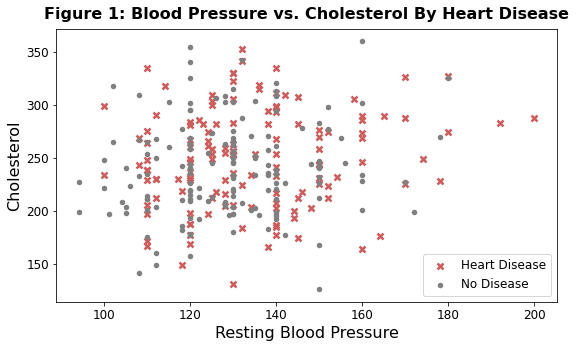

In [43]:
disease = df[df["Output"] == 1]
no_disease = df[df["Output"] == 0]

fig, ax = plt.subplots(figsize=(8,5))

ax.set_ylabel("Cholesterol", fontsize=16,)
ax.set_xlabel("Resting Blood Pressure", fontsize=16,)
ax.set_title("Figure 1: Blood Pressure vs. Cholesterol By Heart Disease", fontsize=16, weight="heavy", pad=10)

ax.scatter(x=disease["Rest BP"], y=disease["Chol"], marker="x", label="Heart Disease", color="indianred", linewidths=2.5)
ax.scatter(x=no_disease["Rest BP"], y=no_disease["Chol"],  marker=".", label="No Disease", color="grey", linewidths=2.5)

ax.legend()

fig.savefig('figure_1.png')

- Notice that although there are a decent amount of individuals with heart disease in the upper right quadrant, we see a somewhat even scattering of individuals with and without heart disease throughout the plot
- This suggests that these two factors alone are not enough for predicting heart disease
    - Proving this, a simple Logistic Regression model that just takes these into account has limited accuracy

In [14]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LogisticRegression())
])

pipe.fit(train[["Chol", "Rest BP"]], train["Output"])
(pipe.score(test[["Chol", "Rest BP"]], test["Output"]) * 100).round(2)

54.79

# Figure 2

## PCA

- Here we will perform a Principal Component Analysis (PCA) to determine whether or not all features should be included in the Logistic Regression

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

### With Standard Scaling

In [15]:
explained_variances_with_scale = []
components = []

pca_df = df.copy()
x = pca_df.loc[:, data_columns].values

    # Separating out the target
out = pca_df.loc[:,["Output"]].values

    # Standardizing the features
x = StandardScaler().fit_transform(x)

for idx in range(1, 14):
    
    pca = PCA(n_components=idx)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents) # might need cols
    
    finalDf = principalDf

    finalDf["Output"] = pca_df["Output"]
    finalDf = finalDf.dropna()
    explained_variances_with_scale.append(sum(pca.explained_variance_ratio_))
    components.append(pca.explained_variance_ratio_)

explained_variances_with_scale    

[0.23801269911370157,
 0.3575725075824593,
 0.4524198788290328,
 0.5388622828850992,
 0.6162826957685816,
 0.685833833835825,
 0.7516131128769792,
 0.8099953474913897,
 0.8625967807739165,
 0.9055901019509367,
 0.9408218712288462,
 0.9724216237849319,
 0.9999999999999999]

In [16]:
components

[array([0.2380127]),
 array([0.2380127 , 0.11955981]),
 array([0.2380127 , 0.11955981, 0.09484737]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 ]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 , 0.07742041]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 , 0.07742041,
        0.06955114]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 , 0.07742041,
        0.06955114, 0.06577928]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 , 0.07742041,
        0.06955114, 0.06577928, 0.05838223]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 , 0.07742041,
        0.06955114, 0.06577928, 0.05838223, 0.05260143]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 , 0.07742041,
        0.06955114, 0.06577928, 0.05838223, 0.05260143, 0.04299332]),
 array([0.2380127 , 0.11955981, 0.09484737, 0.0864424 , 0.07742041,
        0.06955114, 0.06577928, 0.05838223, 0.05260143, 0.04299332,
        0.03523177]),
 array([0.2380127 , 0.11955981, 0.09484737,

### Without Standard Scaling

In [17]:
explained_variances_no_scale = []

pca_df_2 = df.copy()
x = pca_df.loc[:, data_columns].values

# Separating out the target
out = pca_df.loc[:,["Output"]].values

for idx in range(1, 14):
    
    pca = PCA(n_components=idx)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents) # might need cols
    
    finalDf = principalDf
    
    finalDf["Output"] = pca_df["Output"]
    finalDf = finalDf.dropna()
    explained_variances_no_scale.append(sum(pca.explained_variance_ratio_))
    
explained_variances_no_scale

[0.6882805972713609,
 0.8732332605521269,
 0.9777668904996575,
 0.9973821271576342,
 0.9986004733268408,
 0.9989994501053668,
 0.9993091138882374,
 0.9995710193484422,
 0.999784554221304,
 0.9998567991300068,
 0.9999133991604918,
 0.999962876032609,
 1.0000000000000002]

## Plotting Explained Variance by Components

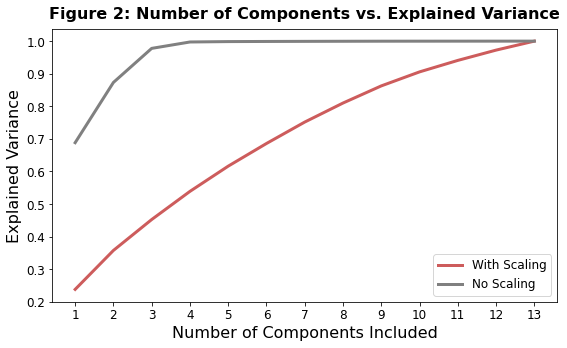

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))

with_scale = pd.Series(explained_variances_with_scale, index=range(1,14))
no_scale = pd.Series(explained_variances_no_scale, index=range(1,14))

ax.set_ylabel("Explained Variance", fontsize=16,)
ax.set_xlabel("Number of Components Included", fontsize=16,)
ax.set_title("Figure 2: Number of Components vs. Explained Variance", fontsize=16, weight="heavy", pad=10)

ax.set_xticks(range(1,14))

ax.plot(with_scale, color="indianred", linewidth=3, label="With Scaling")
ax.plot(no_scale, color="gray", linewidth=3, label="No Scaling")

ax.legend()

fig.savefig('figure_2.png')

- When using standard scaling, we see that using all 13 features is both needed and justified in order to effectively predict heart disease

# Figure 3: Logistic Regression
- Using a sklearn pipeline, we are able to produce a solid score taking all 13 factors into account

In [19]:
train = train.copy()
test = test.copy()

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver = 'lbfgs'))
])

pipe.fit(train[data_columns], train[y])
(pipe.score(test[data_columns], test[y]) * 100).round(2)

84.93

In [20]:
cross_val_score(pipe, test[data_columns], test[y], cv=8).mean() * 100

83.88888888888889

In [21]:
score, garbage_score, p = permutation_test_score(pipe, test[data_columns], test[y])

<AxesSubplot:>

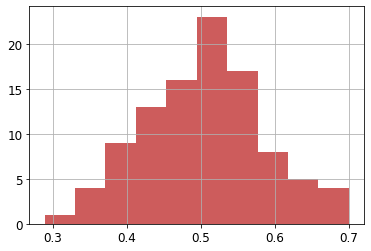

In [22]:
pd.Series(garbage_score).hist(color="indianred")

In [23]:
score

0.8380952380952381

In [24]:
p

0.009900990099009901

Taken from the documentation for permutation_test_score:

"A small p-value suggests that there is a real dependency between features and targets which has been used by the estimator to give good predictions."

Thus, this test suggests that there is indeed a relationship between the features of this data and its target variable, and our model accurately reflects such relationship

## Graphing Coefficients

In [25]:
coefs = list(pipe.named_steps['lr'].coef_[0])
coefs

[-0.025662953490424086,
 0.524532933519156,
 0.515127590180069,
 0.2916302050131358,
 0.38980529251689994,
 -0.09553678539882962,
 0.17215362520336802,
 -0.5116549878453839,
 0.3847099000380757,
 0.47996473555894653,
 0.3633640821969442,
 0.8198012432142059,
 0.701815887492446]

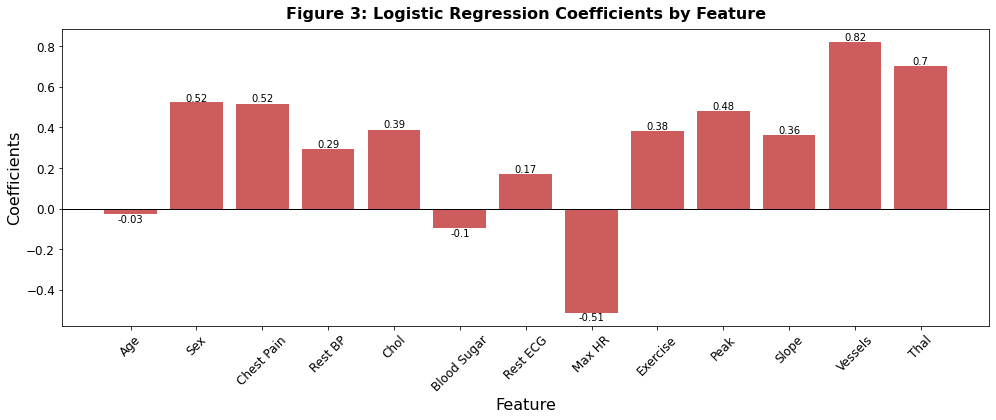

In [45]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
# https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib

fig, ax = plt.subplots(figsize=(14, 6))

ax.axhline(0, color='k', linewidth=1)

ax.set_ylabel("Coefficients", fontsize=16)
ax.set_xlabel("Feature", fontsize=16)
ax.set_title("Figure 3: Logistic Regression Coefficients by Feature", fontsize=16, weight="heavy", pad=10)
plt.xticks(rotation=45)

bars = ax.bar(data_columns, height=coefs, color="indianred")

for bar in bars:
    height = bar.get_height().round(2)
    label_x_pos = bar.get_x() + bar.get_width() / 2
    if height > 0:
        ax.text(label_x_pos, height, s=f'{height}', ha='center',
        va='bottom', fontsize=10)
    else:
        ax.text(label_x_pos, height, s=f'{height}', ha='center',
        va='top', fontsize=10)
    
fig.savefig('figure_3.png')

- We see that factors such as age, one's resting blood pressure, and whether or not they are above a certain threshold for blood sugar have relatively little effect on predicting heart disease
- However, we see that factors such as one's gender, the level of chest pain being experienced, the amount of blood vessels detected, and the presence of Thalassemia have a large effect on predicting heart disease

# Conclusions

- In conclusion, we see that while society largely believes that factors such as cholesterol and blood pressure are main risk factors for heart failure, we see that there are a variety of characteristics at play
- We also see that averaging near 85% accuracy, our model is somewhat effective in predicting heart disease
    - Further improvements would include more data to train the model on, access to the other metrics contained originally by the dataset, and the use of more complex models